# OpenET SSEBop - Interpolated Image Example

Compute total ET for the month of July, 2017 using all available Landsat 8 Collection 1 TOA images.

In [1]:
import datetime
import pprint

import ee
from IPython.display import Image

import openet.ssebop as ssebop
import openet.interp as interp

ee.Initialize()

In [2]:
ndvi_palette = ['#EFE7E1', '#003300']
et_palette = [
  'DEC29B', 'E6CDA1', 'EDD9A6', 'F5E4A9', 'FFF4AD', 'C3E683', '6BCC5C', 
  '3BB369', '20998F', '1C8691', '16678A', '114982', '0B2C7A']

### Input parameters

In [3]:
# Date range you want to aggregate ET over
start_date = '2017-07-01'
end_date = '2017-07-31'

# Only keep images with an average cloud cover less than
cloud_cover = 70

# Number of extra days (at start and end) to include in interpolation
interp_days = 32
# Interpolation method - currently only LINEAR is supported
interp_type = 'LINEAR'

# Use a single point for the filterBounds call in order to only include path 44 / row 33 images
filter_area = ee.Geometry.Point(-121.6, 38.9)
study_area = ee.Geometry.Rectangle(-122.50, 38.50, -121.00, 39.50)

### Computed parameters

In [4]:
# Hard code the study area and CRS
study_region = study_area.bounds(1, 'EPSG:4326').coordinates().getInfo()
study_crs = 'EPSG:32610'

# # Get the study area and CRS from the Landsat collection
# study_transform = landsat_img.select(['B2']).projection().getInfo()['transform']
# study_crs = landsat_img.select(['B2']).projection().crs().getInfo()

In [5]:
# Add extra Landsat images at start and end to interpolate between
interp_start_date = (
    datetime.datetime.strptime(start_date, '%Y-%m-%d') - 
    datetime.timedelta(days=interp_days)).strftime('%Y-%m-%d')
interp_end_date = (
    datetime.datetime.strptime(end_date, '%Y-%m-%d') + 
    datetime.timedelta(days=interp_days)).strftime('%Y-%m-%d')
print(interp_start_date)
print(interp_end_date)

2017-05-30
2017-09-01


### Landsat 8 Collection 1 TOA Image Collection

In [6]:
landsat_coll = ee.ImageCollection('LANDSAT/LC08/C01/T1_RT_TOA') \
    .filterDate(interp_start_date, interp_end_date) \
    .filterBounds(filter_area) \
    .filterMetadata('CLOUD_COVER_LAND', 'less_than', cloud_cover) \
    .filterMetadata('DATA_TYPE', 'equals', 'L1TP')

pprint.pprint(list(landsat_coll.aggregate_histogram('system:index').getInfo().keys()))

['LC08_044033_20170614',
 'LC08_044033_20170630',
 'LC08_044033_20170716',
 'LC08_044033_20170801',
 'LC08_044033_20170817']


### Apply SSEBop Model

In [7]:
# Compute ETf for each Landsat scene
def compute_et_fraction(image):
    return ee.Image(
        ssebop.Image.from_landsat_c1_toa(toa_image=ee.Image(image)).etf)
scene_et_fraction_coll = ee.ImageCollection(landsat_coll.map(compute_et_fraction))

# Daily reference ET collection
daily_et_reference_coll = ee.ImageCollection('IDAHO_EPSCOR/GRIDMET') \
    .filterDate(start_date, end_date) \
    .select(['etr'],['et_reference'])

# Compute composite/mosaic images for each image date
# This will combine Landsat images from the same path into a single image
daily_et_fraction_coll = ee.ImageCollection(interp.aggregate_daily(
    image_coll=scene_et_fraction_coll,
    start_date=interp_start_date,
    end_date=interp_end_date))

# Interpolate daily ETf, multiply by daily ETr, and sum to ET
daily_et_actual_coll = ee.ImageCollection(interp.interpolate(
    et_reference_coll=daily_et_reference_coll,
    et_fraction_coll=daily_et_fraction_coll,
    interp_days=interp_days,
    interp_type=interp_type))

### Total ET over the time period

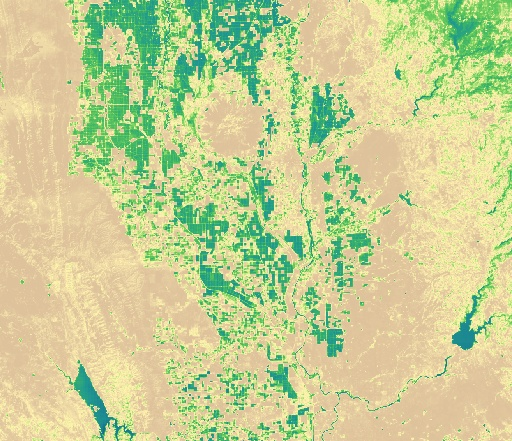

In [8]:
Image(url=ee.Image(daily_et_actual_coll.sum()) \
        .reproject(crs=study_crs, scale=100) \
        .getThumbURL({'min': 0.0, 'max': 400, 'region': study_region, 'palette': ','.join(et_palette)}),
      embed=True, format='png')

### Total ETr over the time period

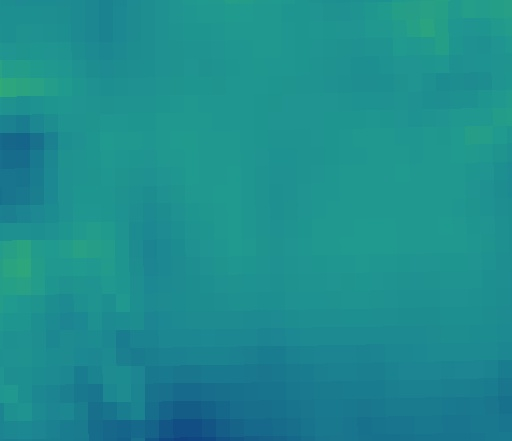

In [9]:
Image(url=ee.Image(daily_et_reference_coll.sum()) \
        .reproject(crs=study_crs, scale=100) \
        .getThumbURL({'min': 0, 'max': 400, 'region': study_region, 'palette': ','.join(et_palette)}),
      embed=True, format='png')

### Mean ETrF over the time period

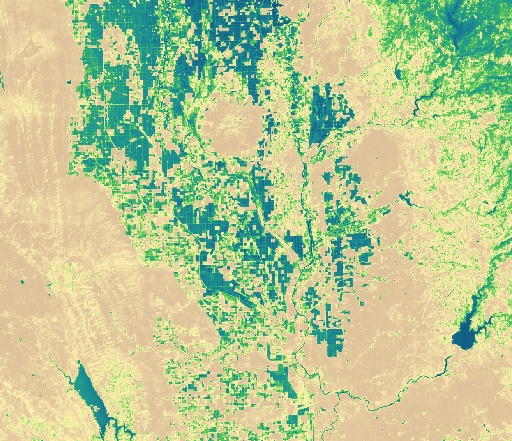

In [10]:
Image(url=ee.Image(daily_et_actual_coll.sum()).divide(ee.Image(daily_et_reference_coll.sum())) \
        .reproject(crs=study_crs, scale=100) # NOTE: Scale is typically 30m but using 100m to draw thumbnail faster \
        .getThumbURL({'min': 0.0, 'max': 1.2, 'region': study_region, 'palette': ','.join(et_palette)}),
      embed=True, format='png')

### Image Count over the time period

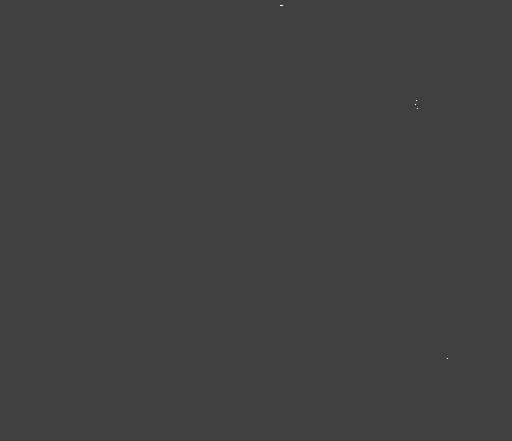

In [11]:
# End date should be advanced 1 day
Image(url=ee.Image(daily_et_fraction_coll.filterDate(start_date, end_date).count()) \
        .reproject(crs=study_crs, scale=100) # NOTE: Scale is typically 30m but using 100m to draw thumbnail faster \
        .getThumbURL({'min': 0.0, 'max': 4, 'region': study_region}),
      embed=True, format='png')